In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
import time

In [2]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

Using Theano backend.


In [3]:
import keras_models.vanPutten as vanPutten
from importlib import reload
reload(vanPutten)
reload(util_funcs)
reload(read)
edfData = read.EdfDataset("train", "01_tcp_ar",filter=True, num_files=10, n_process=6)

In [4]:
import keras_models.vanPutten as vanPutten
from importlib import reload
import wf_analysis.spatialTemporalDatasets as stdata
import clinical_text_analysis as cta

reload(stdata)
reload(vanPutten)
reload(util_funcs)
reload(read)

edfData = read.EdfDataset("train", "01_tcp_ar",filter=True, num_files=150, n_process=8, max_length=pd.Timedelta(seconds=2))
stdataset =  stdata.BasicSpatialDataset(edfData)

import keras_models.dataGen as dg
from importlib import reload
reload(dg)
# edfData.verbose = False

<module 'keras_models.dataGen' from '/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py'>

In [8]:
reload(vanPutten)
model = vanPutten.vp_conv2d(input_shape=(21, 500, 1), use_batch_normalization=True)
model.summary()

/home/ms994/dbmi_eeg_clustering/keras_models/vanPutten.py:112: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Softmax.0, inputs=flatten_1/...)`
  return Model(input=inputs, outputs=x)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 21, 500, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 21, 500, 100)      1000      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 10, 250, 100)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 250, 100)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 250, 100)      400       
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 250, 100)      90100     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 5, 125, 100)       0         
__________

In [5]:
model = keras.models.load_model("../bin_acc_WGAUROFFVZGCQTPL.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
testData = pkl.load(open("../combined_simple_ensemble_test_data.pkl", 'rb'))

In [13]:
x_testData = [datum[0] for datum in testData]
y_testData = [datum[1] for datum in testData]

In [15]:
x_testData = np.stack(x_testData)
x_testData.shape

(26328, 500, 21)

In [16]:
x_testData = x_testData.reshape(*x_testData.shape, 1).transpose(0, 2, 1, 3)

In [17]:
y_pred = model.predict(x_testData)

In [24]:
y_pred = np.array(y_pred).argmax(axis=1)

In [25]:
roc_auc_score(y_testData, y_pred)

0.8573577748610294

In [26]:
testTrainSplit = pkl.load(open("../train_test_split_info.pkl", 'rb'))

In [113]:
needle = x_testData[0].reshape(500, 21)
needle = needle[:, 0]

In [114]:
needle

array([ 3.88201828e+01,  3.29642944e+01,  2.86142044e+01,  4.66001511e+01,
        4.72693939e+01,  3.75653496e+01,  2.40968037e+01,  2.51843262e+01,
        5.21214180e+01,  5.29579773e+01,  2.29256248e+01,  2.71084042e+01,
        1.13811569e+01,  3.63105164e+01,  3.03709717e+01,  2.25910034e+01,
        4.56799393e+01,  4.59309082e+01,  5.09502411e+01,  3.17931175e+01,
        3.93221169e+01,  3.80672836e+01,  4.08279190e+01,  8.07316284e+01,
        1.89938126e+01,  1.41417904e+01,  2.71920586e+01,  4.02423248e+01,
        2.12525139e+01,  1.87428474e+01,  1.76553249e+01,  1.98303699e+01,
        5.64715080e+01,  2.76103363e+01,  9.20611286e+00,  8.87149048e+00,
        8.28590107e+00,  1.42254467e+01,  2.09178925e+01,  2.21727257e+01,
        2.86142044e+01,  3.32152596e+01,  4.49270401e+01,  2.89488258e+01,
        2.81959267e+01,  3.36335373e+01,  1.26359901e+01,  5.93157959e+01,
       -1.08352232e+00, -6.27016735e+00,  5.94354534e+00, -2.92394495e+00,
        2.76939926e+01,  

In [30]:
len(testTrainSplit[1]) == len(x_testData)

False

In [37]:
reload(read)
edfData = read.EdfDataset("combined", "01_tcp_ar")
edfData.edf_tokens = testTrainSplit[1]

In [71]:
datum = edfData[1]

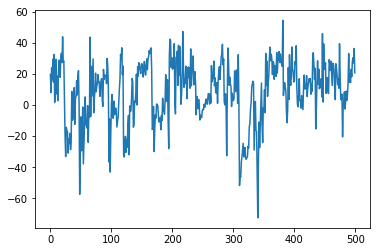

In [83]:
plt.plot(pd.DataFrame(x_testData[1].reshape(500, 21))[0])

In [98]:
target = datum[0][datum[0].columns[0]]

In [123]:
match = target.rolling(500).apply(lambda x: sum(np.abs(x-needle)) if x is not None else 0)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


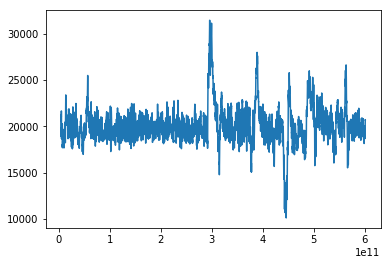

In [124]:
plt.plot(match)

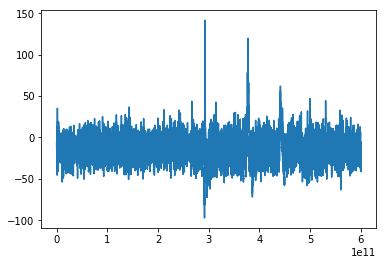

In [84]:
plt.plot()

In [80]:
np.where(datum[0].values == needle)

(array([  174,   194,   221,   235,   410,   418,   430,   433,   444,
          472,   492,   501,  1247,  1255,  1438,  1465,  1472,  1474,
         1513,  1677,  1779,  1793,  1802,  2368,  2509,  2821,  3253,
         3255,  3260,  3450,  3451,  3455,  3459,  3543,  3674,  3916,
         4031,  4253,  4357,  4742,  4869,  5285,  5444,  5444,  5450,
         5462,  5488,  5513,  5647,  5914,  5934,  5945,  5961,  6093,
         6176,  6210,  6218,  6341,  6382,  6387,  6451,  6889,  7151,
         7176,  7199,  7513,  7526,  7526,  7679,  7705,  7708,  7710,
         7711,  7713,  7933,  7962,  8394,  8601,  8602,  8649,  8889,
         8900,  9047,  9371,  9530,  9551,  9618,  9625,  9652,  9828,
         9828,  9831,  9832,  9840,  9874, 10116, 10319, 10330, 10361,
        10399, 10406, 10419, 10583, 10622, 10894, 10899, 11155, 11317,
        11320, 11321, 11389, 11734, 11755, 12091, 12244, 12272, 12281,
        12610, 12650, 12878, 12902, 13040, 13237, 13423, 13506, 13552,
      

In [6]:
import predictGenderConvExp as pgce
reload(pgce)

<module 'predictGenderConvExp' from '/home/ms994/dbmi_eeg_clustering/predictGenderConvExp.py'>

In [33]:
edfData, genders = pgce.get_data("train", "01_tcp_ar", 8, None, 250*2, precached_pkl="../train_data.pkl", use_cached_pkl=True)

In [34]:
testEdfData, testGenders = pgce.get_data("dev_test", "01_tcp_ar", 8, None, 250*2, precached_pkl="../test_data.pkl", use_cached_pkl=True)
# testEdfData = testEdfData[:]

In [12]:
len(testGenders)

764

In [29]:
edg = dg.EdfDataGenerator(dataset=edfData, precache=True, batch_size=64, n_classes=2, labels=genders, time_first=False)

In [30]:
trainEdg, validationEdg = edg.create_validation_train_split(0.2)

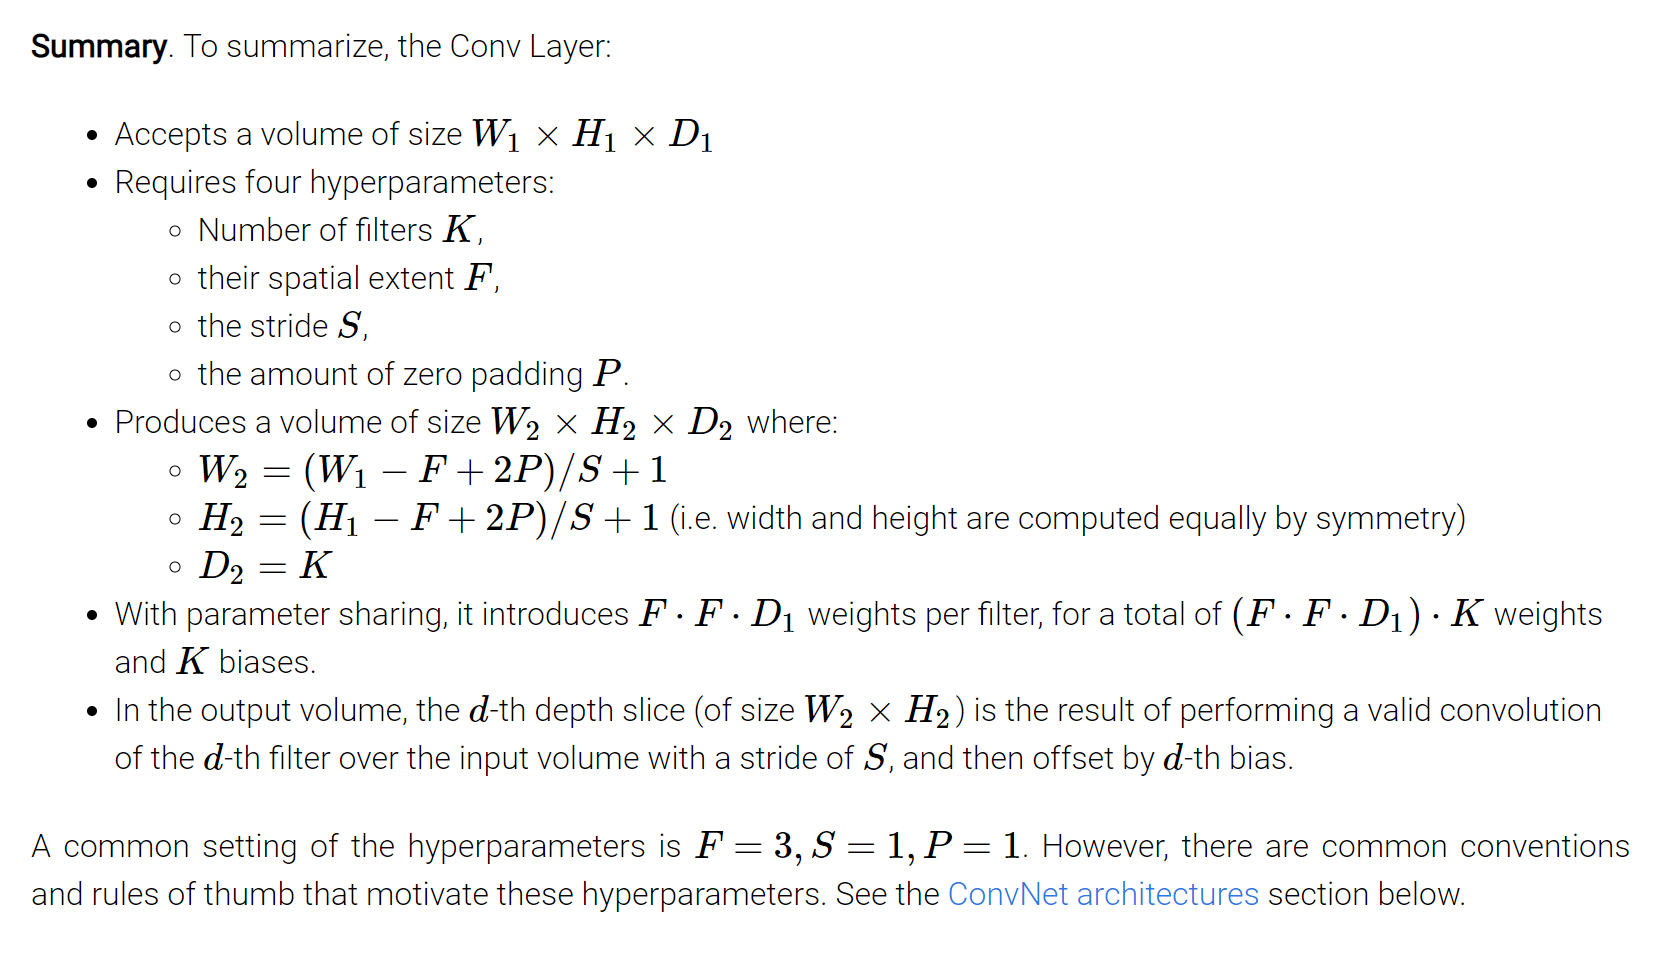

In [39]:
reload(vanPutten)
vp = vanPutten.vp_conv2d(input_shape=(21, 500, 1))

In [40]:
adam = Adam(lr=0.00005)
vp.compile(adam, loss="categorical_crossentropy", metrics=["binary_accuracy"])
# edg.precache=True

In [41]:
vp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 21, 500, 100)      1000      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 10, 250, 100)      0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 10, 250, 100)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 250, 100)      90100     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 5, 125, 100)       0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 125, 100)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 125, 300)       180300    
__________

In [26]:
mc = ModelCheckpoint("bestCnn.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=1)
ec = EarlyStopping(patience=100, verbose=1)

In [32]:
x, y = trainEdg[0]
x.shape

(64, 21, 501, 1)

In [24]:
vp.fit_generator(trainEdg, epochs=1000, callbacks=[mc, ec], validation_data=validationEdg)

Epoch 1/1000
32/32 [==============================] - 6s 194ms/step - loss: 3.4686 - binary_accuracy: 0.5098 - val_loss: 2.1169 - val_binary_accuracy: 0.5410

Epoch 00001: val_binary_accuracy improved from -inf to 0.54102, saving model to bestCnn.h5
Epoch 2/1000
32/32 [==============================] - 1s 30ms/step - loss: 3.0316 - binary_accuracy: 0.5371 - val_loss: 1.8715 - val_binary_accuracy: 0.5645

Epoch 00002: val_binary_accuracy improved from 0.54102 to 0.56445, saving model to bestCnn.h5
Epoch 3/1000
32/32 [==============================] - 1s 31ms/step - loss: 2.8993 - binary_accuracy: 0.5415 - val_loss: 1.6474 - val_binary_accuracy: 0.5605

Epoch 00003: val_binary_accuracy did not improve from 0.56445
Epoch 4/1000
32/32 [==============================] - 1s 31ms/step - loss: 2.9140 - binary_accuracy: 0.5410 - val_loss: 1.5866 - val_binary_accuracy: 0.5723

Epoch 00004: val_binary_accuracy improved from 0.56445 to 0.57227, saving model to bestCnn.h5
Epoch 5/1000
32/32 [======

32/32 [==============================] - 1s 30ms/step - loss: 0.7191 - binary_accuracy: 0.6133 - val_loss: 0.7255 - val_binary_accuracy: 0.5781

Epoch 00074: val_binary_accuracy did not improve from 0.62109
Epoch 75/1000
32/32 [==============================] - 1s 30ms/step - loss: 0.7224 - binary_accuracy: 0.6006 - val_loss: 0.7083 - val_binary_accuracy: 0.5918

Epoch 00075: val_binary_accuracy did not improve from 0.62109
Epoch 76/1000
32/32 [==============================] - 1s 31ms/step - loss: 0.7016 - binary_accuracy: 0.5938 - val_loss: 0.6979 - val_binary_accuracy: 0.5957

Epoch 00076: val_binary_accuracy did not improve from 0.62109
Epoch 77/1000
32/32 [==============================] - 1s 30ms/step - loss: 0.6908 - binary_accuracy: 0.5986 - val_loss: 0.7210 - val_binary_accuracy: 0.5820

Epoch 00077: val_binary_accuracy did not improve from 0.62109
Epoch 78/1000
32/32 [==============================] - 1s 31ms/step - loss: 0.7045 - binary_accuracy: 0.6138 - val_loss: 0.7252 - 

32/32 [==============================] - 22s 692ms/step - loss: 0.6248 - binary_accuracy: 0.6426 - val_loss: 0.8028 - val_binary_accuracy: 0.5996

Epoch 00148: val_binary_accuracy did not improve from 0.62305
Epoch 149/1000
32/32 [==============================] - 1s 30ms/step - loss: 0.6062 - binary_accuracy: 0.6489 - val_loss: 0.8308 - val_binary_accuracy: 0.5918

Epoch 00149: val_binary_accuracy did not improve from 0.62305
Epoch 150/1000
32/32 [==============================] - 1s 31ms/step - loss: 0.6144 - binary_accuracy: 0.6567 - val_loss: 0.7925 - val_binary_accuracy: 0.6094

Epoch 00150: val_binary_accuracy did not improve from 0.62305
Epoch 151/1000
32/32 [==============================] - 1s 30ms/step - loss: 0.6155 - binary_accuracy: 0.6562 - val_loss: 0.8047 - val_binary_accuracy: 0.6094

Epoch 00151: val_binary_accuracy did not improve from 0.62305
Epoch 152/1000
32/32 [==============================] - 1s 31ms/step - loss: 0.6370 - binary_accuracy: 0.6392 - val_loss: 0.8

In [25]:
model = keras.models.load_model("bestCnn.h5")

In [28]:
y_pred = model.predict(np.stack([datum[0] for datum in edg.dataset]).reshape(len(edg.dataset),501,21,1).transpose(0,2,1,3))

In [29]:
accuracy_score(y_pred.argmax(axis=1), edg.labels), roc_auc_score(y_pred.argmax(axis=1), edg.labels)

(0.6520244461420932, 0.6526746038031379)

In [30]:
testEdfData = testEdfData[:]

In [31]:
y_pred = model.predict(np.stack([datum[0] for datum in testEdfData[:]]).reshape(len(testEdfData), 250*2 + 1, 21, 1).transpose(0,2,1,3))

In [32]:
y_pred.argmax(axis=1).shape, len(testGenders)

((764,), 764)

In [33]:
accuracy_score(y_pred.argmax(axis=1), testGenders), roc_auc_score(y_pred.argmax(axis=1), testGenders)

(0.518324607329843, 0.5219072164948453)

In [34]:
x, y, etc = roc_curve(testGenders, y_pred[:,1]/y_pred.sum(axis=1))

Text(0, 0.5, 'TPR')

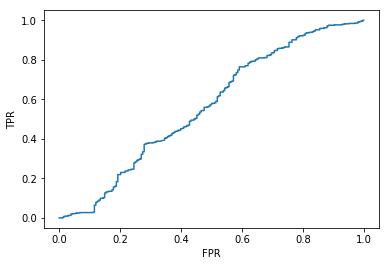

In [35]:
plt.plot(x, y)
plt.xlabel("FPR")
plt.ylabel("TPR")

In [36]:
confusion_matrix(y_pred.argmax(axis=1), testGenders)

array([[114, 274],
       [ 94, 282]])